# Trees and Forests

> Building a simple Decision Tree Classifier!
>
> *Author:* Bjarne C. Hiller

In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

## Ingredients

- `np.unique` and `np.unique_counts`
- `np.argmax`

## Implementation

Let's start with a simple class to hold the decision rules associated with each tree node.
Each decision rule splits the data by comparing one of the *features* against a *threshold value*. 

In [2]:
class TreeNode:
    """Represents one split in the Decision Tree."""

    def __init__(self, feature=None, value=None):
        self.left = None
        self.right = None
        self.feature = feature
        self.value = value
        self.samples = None
    
    def split(self, X):
        left = X[..., self.feature] < self.value
        return left, ~left
    
    def is_leaf(self):
        """Is this a leaf node?"""
        return (self.left is None) and (self.right is None)

    def __repr__(self):
        if self.is_leaf():
            return f"TreeNode({self.samples})"
        return f"TreeNode({self.samples}, {self.feature} < {self.value:.2f})"

Next, we will write a class that generates split candidates.
One of the simplest approaches is to use the median of each feature as split value:

In [3]:
class Splitter:

    def make_splits(self, X, y) -> list[TreeNode]:
        """Generates candidate splits."""
        pass

class MedianSplitter(Splitter):
    """Generates splits by using the Median for each feature."""

    def make_splits(self, X, y) -> list[TreeNode]:
        n, p = X.shape
        splits = []
        medians = np.median(X, axis=0)
        for i in range(p):
            node = TreeNode(feature=i, value=medians[i])
            splits.append(node)
        return splits

Now, we need some criterion to evaluate the generated splits and pick the best candidate:

In [4]:
class Criterion:
    def evaluate(self, X, y, split: TreeNode):
        pass

    def __call__(self, X, y, split: TreeNode):
        return self.evaluate(X, y, split)

The *Gini index*, named after the mathematician Corrado Gini, is a measure of class impurity, that the Decision Tree tries to minimize.
It represents, of how often a randomly chosen instance would be incorrectly labeled, if labels were decided randomly according to the relative number of instances of the respective class.

Let $Y$ be a multiset of class labels from the underlying class set $C=\{1, ..., c\}$. Then the relative frequencies $p_i$ of each class $i\in C$ is given by:

$$
    p_i = \frac{|\{y \in Y | y=i\}|}{|Y|}
$$

Then, the gini index $I_G$ can be computed as:

$$
    \begin{align*}
    I_G(p)
        &= \sum_{i=1}^c \left( p_i \sum_{j \neq i} p_j \right)\\
        &= \sum_{i=1}^c p_i (1 - p_i)\\
        &= \sum_{i=1}^c (p_i - p_i^2)\\
        &= \sum_{i=1}^c p_i - \sum_{i=1}^c p_i^2\\
        &= 1 - \sum_{i=1}^c p_i^2
    \end{align*}
$$

A gini index of 0 means, that all instances belong to the same class.

In [5]:
def gini_index(labels) -> float:
    """Computes the Gini-Index for a given numpy array of labels."""
    gini = 0
    # TODO: Implement computation of the Gini-Index!
    return gini

In [6]:
def gini_index(labels) -> float:
    """Computes the Gini-Index for a given numpy array of labels."""
    _, counts = np.unique_counts(labels)
    p = counts / counts.sum()
    return 1 - np.power(p, 2).sum()

In [7]:
assert gini_index([0,0,0]) == 0
assert gini_index([0,1]) == 0.5

In [8]:
class GiniCriterion(Criterion):
    """Evaluates splits using the gini index."""
 
    def evaluate(self, X, y, split: TreeNode):
        left, right = split.split(X)
        gini = gini_index(y)
        gini_left = 0
        if len(y[left]) > 0:
            gini_left = len(y[left]) / len(y) * gini_index(y[left])
        gini_right = 0
        if len(y[right]) > 0:
            gini_right = len(y[right]) / len(y) * gini_index(y[right])
        return gini - gini_left - gini_right

Finally, we will bring everything together in this `Tree` class. At each node, the tree will generate new candidate splits with the Splitter object, evaluate them with the criterion, and use the best candidate to split the data into a left and a right child node. This will continue, until all samples belong to the same class or the maximum depth is reached:

In [9]:
class Tree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, criterion="gini", splitter="median"):
        super().__init__()
        self.max_depth = max_depth
        self.root_ = None
        self.classes_ = None
        self.criterion = criterion
        if self.criterion == "gini":
            self.criterion = GiniCriterion()
        self.splitter = splitter
        if self.splitter == "median":
            self.splitter = MedianSplitter()
    
    def fit(self, X, y):
        # save class labels observed in training data
        self.classes_ = np.unique(y)

        # recursively grow tree and return root node
        self.root_ = self.grow(X, y, 1)

    def class_counts(self, y):
        """Helper function to receive class counts."""
        bins = np.zeros_like(self.classes_)
        for i, c in enumerate(self.classes_):
            bins[i] = np.sum(y == c)        
        return bins
    
    def grow(self, X, y, depth):
        """Recursively grow a tree."""
        n, p = X.shape
        samples = self.class_counts(y)

        # return leaf node
        if len(np.unique(y)) <= 1 or (self.max_depth is not None and depth >= self.max_depth):
            leaf = TreeNode()
            leaf.samples = samples
            return leaf

        # generate splits
        splits = self.splitter.make_splits(X, y)

        # evaluate splits and aggregate scores
        scores = [self.criterion.evaluate(X, y, split) for split in splits]       

        # gest best split
        node = splits[np.argmax(scores)]
        node.samples = samples
        left, right = node.split(X)

        # check for degenerate splits
        if len(y[left]) == 0 or len(y[left]) == 0:
            leaf = TreeNode()
            leaf.samples = samples
            return leaf

        # grow left and right children
        node.left = self.grow(X[left], y[left], depth+1)
        node.right = self.grow(X[right], y[right], depth+1)
        return node
    
    def traverse(self, x) -> TreeNode:
        node = self.root_
        while not node.is_leaf():
            left, right = node.split(x)
            if left.all():
                node = node.left
            else:
                node = node.right
        return node

    def predict(self, X):
        predictions = []
        for x in X:
            # get leaf nod
            leaf = self.traverse(x)
            main_class = np.argmax(leaf.samples)
            y = self.classes_[main_class]
            predictions.append(y)
        return predictions

    def __str__(self):
        text = ""
        nodes = [self.root_]
        while nodes:
            text += "\t".join([str(n) for n in nodes]) + "\n"
            nodes = sum([[n.left, n.right] for n in nodes], start=[])
            nodes = [n for n in nodes if n is not None]
        return text

## Test on Iris Dataset

Let's try out our implementation on the iris dataset:

In [10]:
iris_ds = load_iris()

# only use petal length and petal width
X = iris_ds["data"][:, [2,3]]
y = iris_ds["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=19)

In [11]:
tree = Tree()
tree.fit(X_train, y_train)

In [12]:
tree.root_

TreeNode([40 38 42], 0 < 4.45)

In [13]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.2f} %")

Test Accuracy: 0.97 %


In [14]:
tree

Tree(criterion=<__main__.GiniCriterion object at 0x7fcabffaab10>,
     splitter=<__main__.MedianSplitter object at 0x7fcabffaabd0>)

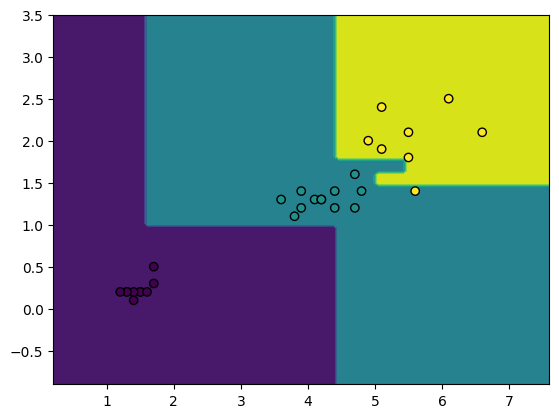

In [15]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

DecisionBoundaryDisplay.from_estimator(tree, X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolors="k");

## Outlook

Fortunately, `sklearn` already provides an implementation via the `DecisionTreeClassifier` and `DecisionTreeRegressor`

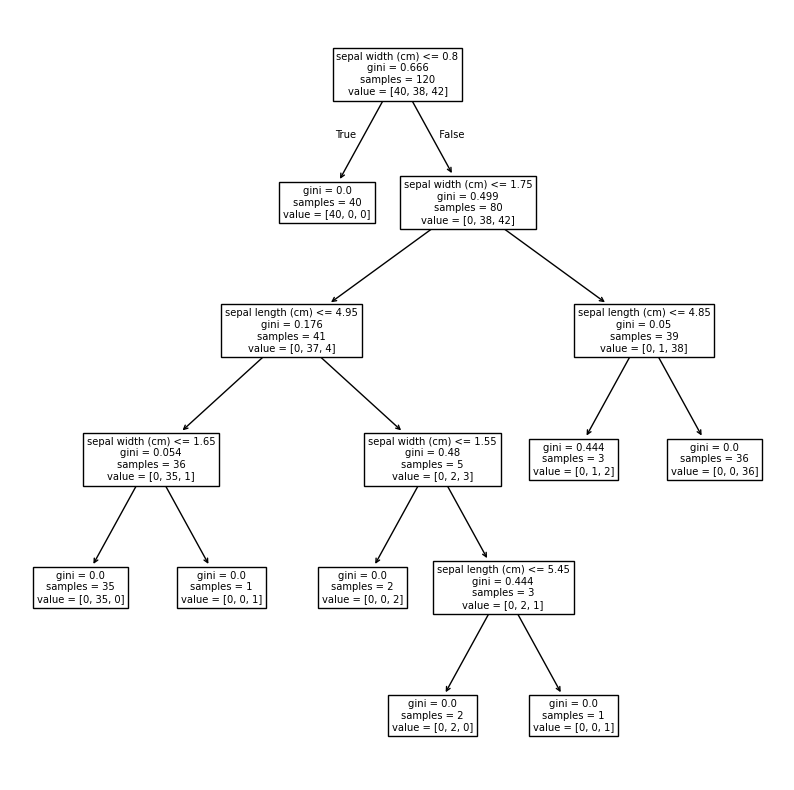

In [16]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

model = DecisionTreeClassifier()

fig, ax = plt.subplots(figsize=(10,10))
model.fit(X_train, y_train)
plot_tree(model, feature_names=iris_ds["feature_names"], ax=ax);